In [1]:
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm

In [2]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'data/train.p'
validation_file= 'data/valid.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']
print(train['coords'].shape)
print(len(y_train))
print(train['features'].shape)

(34799, 4)
34799
(34799, 32, 32, 3)


In [3]:
n_train = len(y_train)
n_validation = len(y_valid)
n_test = len(y_test)
image_shape = X_train.shape[1:]
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [4]:
sign_df = pd.read_csv('signnames.csv')
sign_df = sign_df.set_index(['ClassId'])

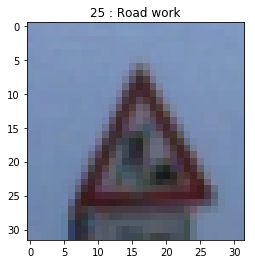

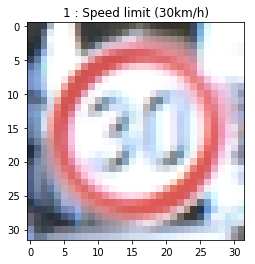

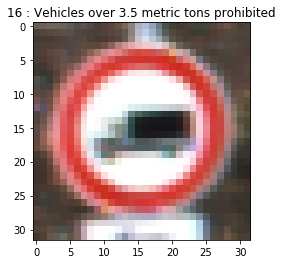

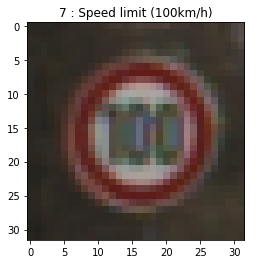

In [5]:
idx = np.random.choice(np.arange(n_train), 4)
for i in idx:
    title = '{} : {}'.format(y_train[i], sign_df.iloc[y_train[i]]['SignName'])
    plt.imshow(X_train[i])
    plt.title(title)
    plt.show()

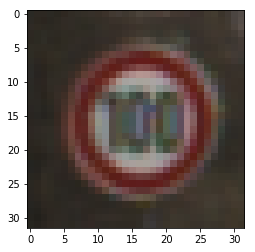

In [6]:
import cv2
plt.imshow(X_train[i])
plt.show()
test_img = X_train[i].copy()

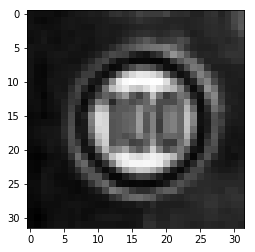

In [7]:
# converting into YUV
res = cv2.cvtColor(test_img, cv2.COLOR_BGR2YUV)
Y = res[:,:,0]
U = res[:,:,1]
v = res[:,:,2]
plt.imshow(Y, cmap='gray')

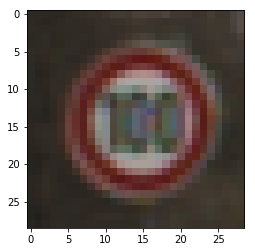

In [8]:
# resizing
res = cv2.resize(test_img, (29,29), fx=0, fy=0, interpolation = cv2.INTER_CUBIC)
plt.imshow(res)

(20, 20, 6)
6 26


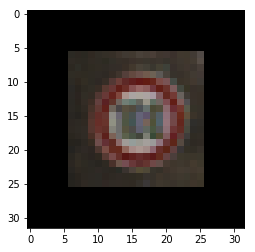

In [9]:
target_size = 20 # i.e. 0.9 scale
#target_size = 36 # i.e. 1.1 scale


test_input = np.concatenate((test_img, test_img), axis=2)

res = cv2.resize(test_input, (target_size, target_size), fx=0, fy=0, interpolation = cv2.INTER_CUBIC)
print(res.shape)

if target_size > 32:
    start_idx = (target_size - 32)//2
    end_idx = start_idx + 32
    print(start_idx, end_idx)
    res_32 = res[start_idx:end_idx,start_idx:end_idx,:]
    print(res_32.shape)
    plt.imshow(res_32)
else:
    dst = np.zeros_like(test_input)
    start_idx = (32 - target_size)//2
    end_idx = start_idx + target_size
    print(start_idx, end_idx)
    dst[start_idx:end_idx,start_idx:end_idx,:] = res
    plt.imshow(dst[:,:,3:6])

In [10]:
def resize_img(input_img, target_size=36):
    input_size = input_img.shape[0]
    assert input_img.shape[0] == input_img.shape[1] # square img
    if input_size == target_size:
        return input_img
    
    res = cv2.resize(input_img, (target_size, target_size), fx=0, fy=0, interpolation = cv2.INTER_CUBIC)

    if target_size > input_size:
        start_idx = (target_size - input_size)//2
        end_idx = start_idx + input_size
        dst = res[start_idx:end_idx,start_idx:end_idx,:]
    else:
        dst = np.zeros_like(input_img)
        start_idx = (input_size - target_size)//2
        end_idx = start_idx + target_size
        dst[start_idx:end_idx,start_idx:end_idx,:] = res
    
    return dst

def resize_batch(X):
    X_out=[]

    for xx in tqdm(X):
        resized_xx = resize_img(xx, target_size=36)
        X_out.append(resized_xx)
        resized_xx = resize_img(xx, target_size=28)
        X_out.append(resized_xx)
    
    X_out = np.asarray(X_out)
    return X_out

print(X_train.shape)
X_train_resized = resize_batch(X_train)
print(X_train_resized.shape)

(34799, 32, 32, 3)


100%|█████████████████████████████████████████████████████████████████████████| 34799/34799 [00:01<00:00, 26800.37it/s]


(69598, 32, 32, 3)


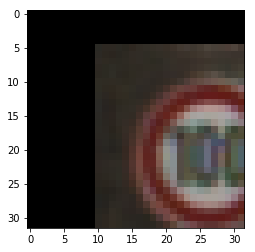

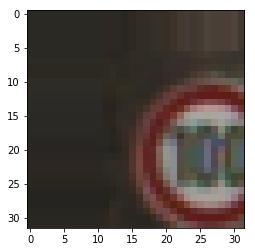

In [64]:
# shifting
rows,cols, ch = test_img.shape

M = np.float32([[1,0,10],[0,1,5]])
dst = cv2.warpAffine(test_img,M,(cols,rows))

plt.imshow(dst)
plt.show()

dst = cv2.warpAffine(np.concatenate([test_img, test_img], axis=2),M,(cols,rows), borderMode=1)
# borderMode 
# 0 == fill zero
# 1 == replicate
# 2 == reflect
# 3 == wrap around
# 4 == reflect_101

plt.imshow(dst[:,:,3:6])
plt.show()

In [12]:
def shift_img(input_img, dx=2, dy=2):
    
    if dx==0 and dy==0:
        return input_img
    
    M = np.float32([[1,0,dx],[0,1,dy]])
    dst = cv2.warpAffine(input_img,M,(input_img.shape[0],input_img.shape[1]))

    return dst

def shift_batch(X):
    X_out=[]

    for xx in tqdm(X):
        for dx in [-2, 0, 2]:
            for dy in [-2, 0, 2]:
                if dx==0 and dy==0:
                    continue
                else:
                    s_xx = shift_img(xx, dx=dx, dy=dy)
                    X_out.append(s_xx)
    
    X_out = np.asarray(X_out)
    return X_out

print(X_train.shape)
X_train_shifted = shift_batch(X_train)
print(X_train_shifted.shape)

(34799, 32, 32, 3)


100%|██████████████████████████████████████████████████████████████████████████| 34799/34799 [00:03<00:00, 9070.03it/s]


(278392, 32, 32, 3)


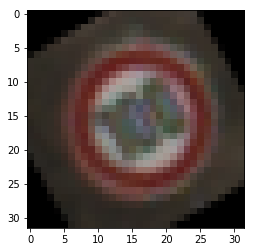

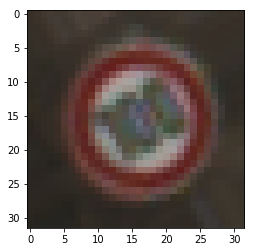

In [49]:
# rotate
rows,cols, ch = test_img.shape
angle=30

M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
dst = cv2.warpAffine(test_img,M,(cols,rows))

plt.imshow(dst)
plt.show()

dst = cv2.warpAffine(np.concatenate([test_img, test_img], axis=2),M,(cols,rows), borderMode=1)

plt.imshow(dst[:,:,3:6])
plt.show()

In [14]:
def rotate_img(input_img, angle=0):
    
    if angle==0:
        return input_img
    
    rows,cols, ch = input_img.shape

    M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
    dst = cv2.warpAffine(input_img,M,(cols,rows))

    return dst

def rotate_batch(X):
    X_out=[]

    for xx in tqdm(X):
        for ang in [-15, 15]:
            r_xx = rotate_img(xx, angle=ang)
            X_out.append(r_xx)
    
    X_out = np.asarray(X_out)
    return X_out

print(X_train.shape)
X_train_rotated = rotate_batch(X_train)
print(X_train_rotated.shape)

(34799, 32, 32, 3)


100%|█████████████████████████████████████████████████████████████████████████| 34799/34799 [00:00<00:00, 36667.04it/s]


(69598, 32, 32, 3)


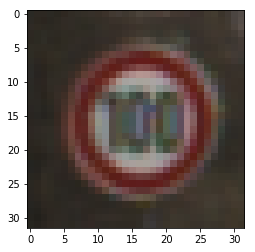

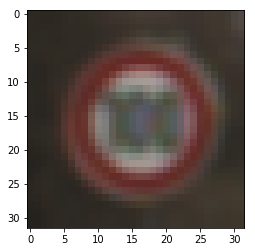

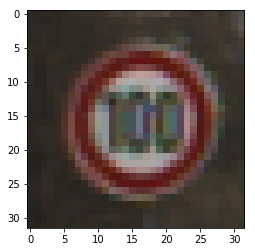

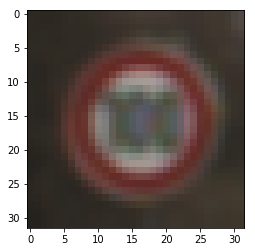

In [67]:
# blur and sharpen
kernel = (3,3)

dst = cv2.GaussianBlur(test_img, kernel, 0)
plt.imshow(test_img)
plt.show()

plt.imshow(dst)
plt.show()

sharp = cv2.addWeighted(test_img, 1.5, dst, -0.5, 0)
plt.imshow(sharp)
plt.show()

dst = cv2.GaussianBlur(np.concatenate([test_img, test_img], axis=2), kernel, 0)

plt.imshow(dst[:,:,3:6])
plt.show()

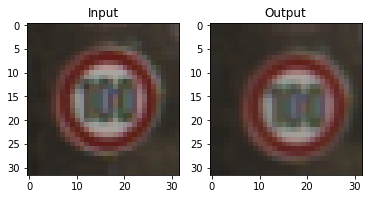

(32, 32, 3)

In [103]:
# warp perspective
rows,cols,ch = test_img.shape

#pts1 = np.float32([[5,-5],[38,0],[0,31],[31,31]])
#pts1 = np.float32([[5,5],[26,5],[5,26],[26,26]])
#pts1 = np.float32([[-5,-5],[31+5,-5],[-5,31+5],[31+5,31+5]])
pts1 = np.float32([[-5,-5],[31-5,-5],[-5,31-5],[31-5,31-5]])
pts2 = np.float32([[0,0],[31,0],[0,31],[31,31]])
#pts1 = np.float32(pts2 + np.random.uniform(-3, 3, pts2.shape))
#print(pts1.dtype)

pts1 = np.float32(pts2 + -1.3)

M = cv2.getPerspectiveTransform(pts1,pts2)

dst = cv2.warpPerspective(test_img,M,(32,32), borderMode=1)

plt.subplot(121),plt.imshow(test_img),plt.title('Input')
plt.subplot(122),plt.imshow(dst),plt.title('Output')
plt.show()
dst.shape

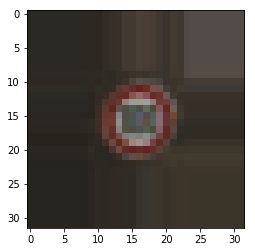

In [114]:
import tsc_utils as tu
import imp
tu = imp.reload(tu)
plt.imshow(tu.resize_img(test_img, scale=1.5))

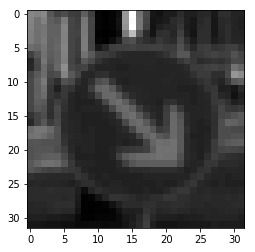

In [88]:
Y = cv2.cvtColor(X_train[15020], cv2.COLOR_BGR2GRAY)
plt.imshow(Y, cmap='gray')

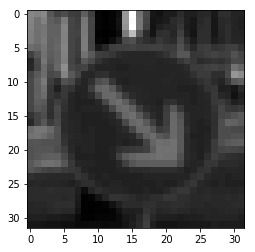

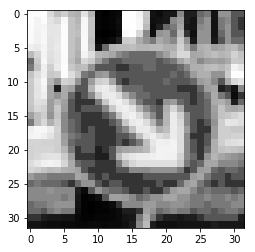

In [18]:
# hist equalization
equ = cv2.equalizeHist(Y)
res = np.hstack((Y,equ)) #stacking images side-by-side
plt.imshow(Y, cmap='gray')
plt.show()
plt.imshow(equ, cmap='gray')

(array([   4.,    0.,   13.,    0.,    0.,   13.,    0.,    0.,    0.,
           0.,    4.,    0.,    8.,    0.,    0.,    3.,    0.,    0.,
           8.,    0.,   11.,    0.,    0.,   15.,    0.,    6.,    0.,
           0.,   15.,    0.,    0.,   23.,    0.,   88.,    0.,    0.,
         139.,    0.,   76.,    0.,    0.,   61.,    0.,   65.,    0.,
           0.,   44.,    0.,    0.,   31.,    0.,   16.,    0.,    0.,
          23.,    0.,   16.,    0.,    0.,   22.,    0.,    0.,   24.,
           0.,   20.,    0.,    0.,   15.,    0.,   25.,    0.,    0.,
          16.,    0.,   11.,    0.,    0.,   11.,    0.,    0.,    6.,
           0.,   14.,    0.,    0.,   11.,    0.,   12.,    0.,    0.,
          19.,    0.,    0.,   12.,    0.,   11.,    0.,    0.,    8.,
           0.,    9.,    0.,    0.,   10.,    0.,    0.,    9.,    0.,
          12.,    0.,    0.,    8.,    0.,   14.,    0.,    0.,    3.,
           0.,    7.,    0.,    0.,    5.,    0.,    0.,    4.,    0.,
      

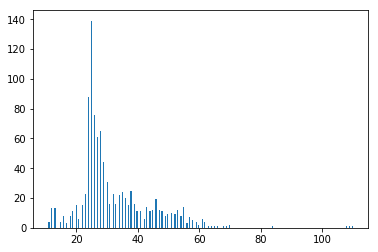

In [19]:
plt.hist(Y.reshape((-1,)), bins=256)

(array([   4.,    0.,    0.,   13.,    0.,    0.,   13.,    0.,    4.,
           0.,   11.,    0.,    8.,    0.,    0.,   11.,    0.,    0.,
           0.,   15.,    6.,    0.,    0.,    0.,   15.,    0.,    0.,
           0.,    0.,    0.,   23.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,   88.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,  139.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,   76.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,   61.,    0.,    0.,    0.,    0.,
      

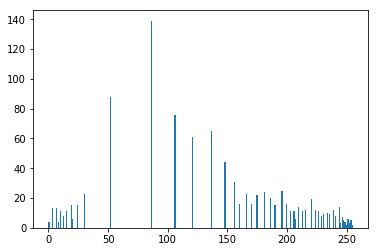

In [20]:
plt.hist(equ.reshape((-1,)), bins=256)

In [21]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
cl1 = clahe.apply(Y)

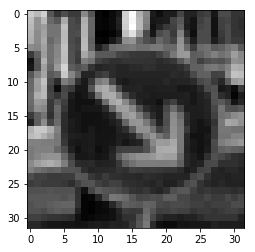

In [22]:
plt.imshow(cl1, cmap='gray')

In [23]:
nn = (cl1 - cl1.mean())/cl1.std()
nn.std()

cl1.dtype

dtype('uint8')

In [24]:
import cv2
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))

from tqdm import tqdm

def color_cvt(X, use_grayscale=True, keep_original=True, sharpen_all=True, normed = True):
    X_out=[]
    
    if use_grayscale:
        color_method = cv2.COLOR_BGR2GRAY
    else:
        color_method = cv2.COLOR_BGR2YUV
    
    for xx in tqdm(X):
        res = cv2.cvtColor(xx, color_method)
        if len(res.shape)<3:
            res = np.expand_dims(res, axis=2)
        
        if keep_original:
            res = np.concatenate([res, xx], axis=2)
        
        if sharpen_all:
            for i in range(res.shape[-1]):
                res[:,:,i] = clahe.apply(res[:,:,i])
        else: # only sharpening channel 0, assuming this is a grayscale channel!!!!!
            res[:,:,0] = clahe.apply(res[:,:,0])
            
        if normed:
            res = res.astype(float)        
            for i in range(res.shape[-1]): # normalize to 0 mean, and 1 stdev
                res[:,:,i] = (res[:,:,i] - res[:,:,i].mean())/res[:,:,i].std()
                #mean = res[:,:,i].mean()
                #std = res[:,:,i].std()
                #print(mean, std)
                #assert np.isclose(mean, 0.0), 'mean is not close to 0.0'
                #assert np.isclose(std, 1.0), 'std is not close to 1.0'
        
        X_out.append(res)
    
    X_out = np.asarray(X_out)
    return X_out

X_train_new = color_cvt(X_train)
print(X_train_new.shape)


100%|██████████████████████████████████████████████████████████████████████████| 34799/34799 [00:11<00:00, 3130.80it/s]


(34799, 32, 32, 4)


In [25]:
xx=X_train[0]

In [26]:
res = cv2.cvtColor(xx, color_method)
if len(res.shape)<3:
    res = np.expand_dims(res, axis=2)
res[:,:,0] = clahe.apply(res[:,:,0])

NameError: name 'color_method' is not defined

In [27]:
((res[:,:,0]-res[:,:,0].mean())/49.817).mean()

IndexError: too many indices for array

In [28]:
i = 0
a=(res[:,:,i] - res[:,:,i].mean())/res[:,:,i].std()

IndexError: too many indices for array

In [ ]:
res[:,:,i] = a
res[:,:,i]

In [ ]:
for i in range(res.shape[-1]): # normalize to 0 mean, and 1 stdev
    res[:,:,i] = (res[:,:,i] - res[:,:,i].mean())/res[:,:,i].std()
    mean = res[:,:,i].mean()
    std = res[:,:,i].std()
    print(mean, std)